In [1]:
%load_ext autoreload
%autoreload 2

In [129]:
import gdown
import pandas as pd
import os

#forcasting
from genrisk.utils.data_processor import AddImmutable
from genrisk.forecasting.forcasting import ARIMAModelHandler, LSTMModelHandler, TFTModelHandler

#generation
from genrisk.generation.tcn_gan import TCNGAN
from genrisk.utils.evaluation import *

#worst-risk case
from genrisk.shift import *
from genrisk.utils.plot import *

## Load dataset

In [3]:
def load_gas_supply():
    if not os.path.exists("gas_supply.csv"):
        gdown.download(
            "https://drive.google.com/uc?id=1kGp65UabcFcKAHSM4K2MgkPAYgbyhQj5",
            "gas_supply.csv",
        )
    target = pd.read_csv(
        "gas_supply.csv",
        skiprows=5,
        header=None,
        date_parser=pd.to_datetime,
        index_col=0,
    )
    target = target.sort_index().asfreq("W-Fri")
    target = target.rename(columns={1: "supply"})
    target.index.name = "date"
    target = target.iloc[:1500]
    return target

In [4]:
df_gas = load_gas_supply()

## Data preparation

add exogenous variable

In [5]:
df = AddImmutable(df_gas, ['weekofyear'])

In [6]:
df = df.get()

In [27]:
train = df[:int(len(df)*0.9)]
test = df[int(len(df)*0.9):]

## Forcasting model

In [7]:
def plot_predictions(future_pred, future_target):
    if not isinstance(future_pred, list):
        future_pred = list(future_pred.values())
    if not isinstance(future_pred, list):
        future_target = list(future_target.values())
    plt.figure(figsize=(10, 5))
    plt.plot(future_target, label="real_values")
    plt.plot(future_pred, label="predicted_values", linestyle="--")

    plt.legend()
    plt.title("Comparison of test and predict")
    plt.xlabel("Index")
    plt.ylabel("Values")

    plt.show()

training model

разделить трейн и тест

In [29]:
arima = ARIMAModelHandler(train = train,
                          test = test, 
                          test_percent = 0.1, 
                          forecasting_horizont = 24,
                          target_columns = ['supply'],
                          conditional_columns = ['weekofyear_cos', 'weekofyear_sin'],)
tmp = arima.train_model()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17539.164, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17240.430, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17076.746, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17537.213, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=17077.832, Time=0.90 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=17078.435, Time=1.39 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=17078.938, Time=1.29 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=17076.912, Time=1.18 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=17080.402, Time=5.64 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=17535.269, Time=0.67 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=17078.958, Time=2.19 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=17078.787, Time=1.96 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=17240.498, Time=0.96 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=5.64 sec
 ARIMA(0,1,1)(0,0,1)[7]  

In [30]:
arima.save_model()

In [31]:
arima.load_model()


get prediction

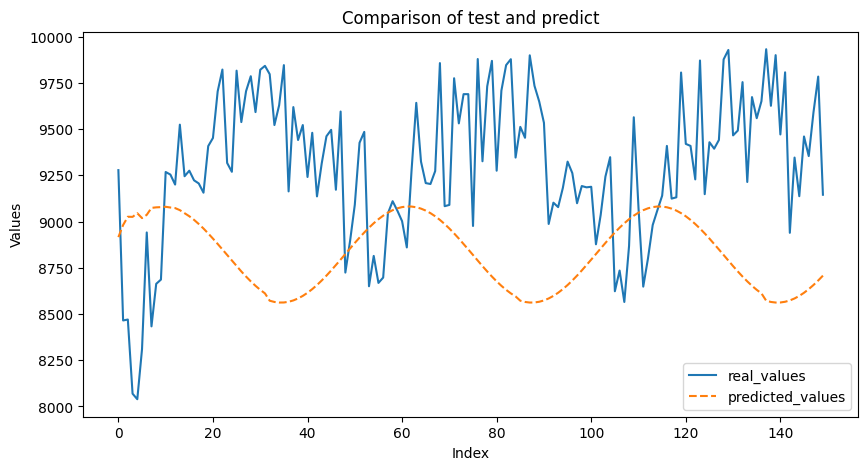

In [32]:
test_ts_values = list(arima.get_true_test().values) 
ans_values = list(arima.forecast().values)  

plot_predictions(ans_values, test_ts_values) 

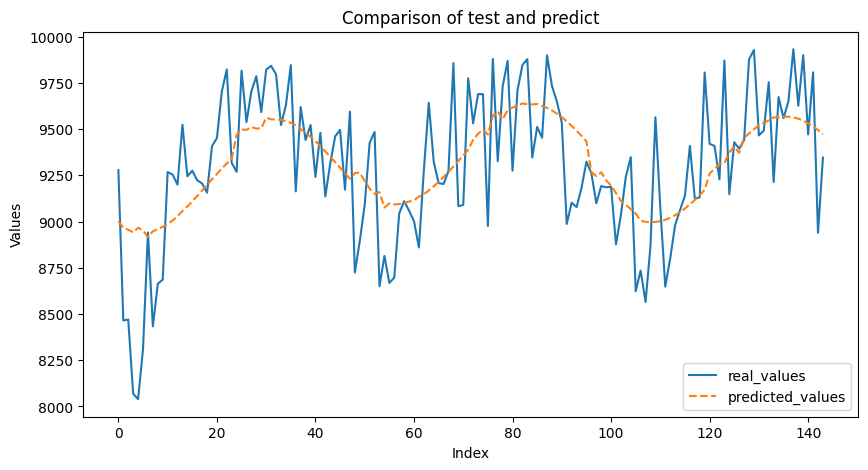

In [12]:
future_pred, future_target = arima.backtest()

plot_predictions(list(future_pred), list(future_target)) 

----

In [33]:
lstm = LSTMModelHandler(train = train,
                          test = test, 
                          test_percent = 0.1, 
                          forecasting_horizont = 24,
                          target_columns = ['supply'],
                          conditional_columns = ['weekofyear_cos', 'weekofyear_sin'],)
# lstm.train_model()

In [23]:
lstm.save_model()

In [14]:
lstm.load_model()

get prediction on the backtest

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


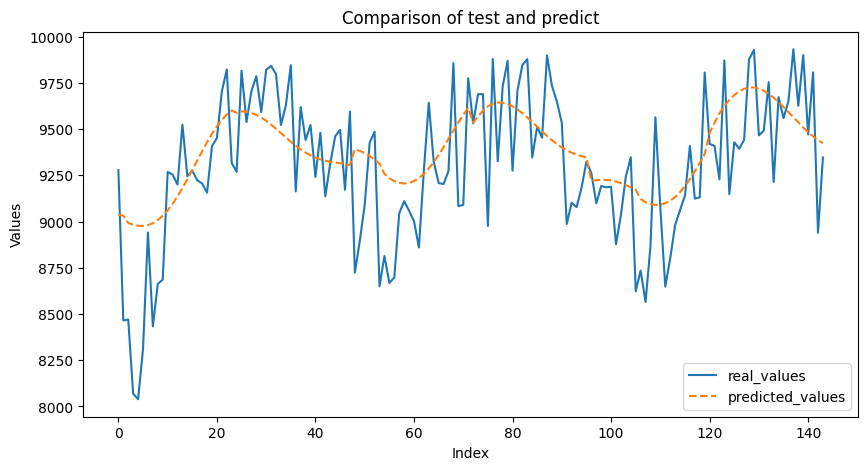

In [15]:
future_pred, future_target = lstm.backtest()

plot_predictions(list(future_pred), list(future_target)) 

get prediction

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


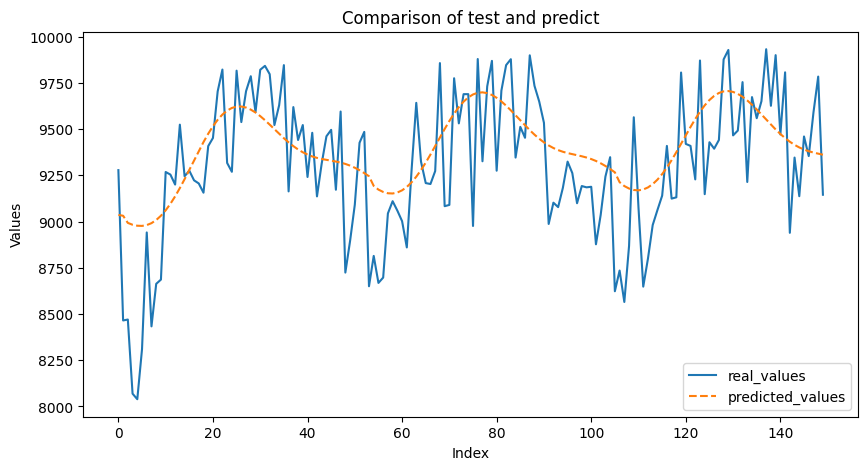

In [17]:
ans = lstm.forecast()

test_ts_values = list(lstm.get_true_test().values) 
ans_values = list(ans.values)  

plot_predictions(ans_values, test_ts_values) 

---

In [18]:
tft = TFTModelHandler(dataset = df, 
                          test_percent = 0.1, 
                          forecasting_horizont = 24,
                          target_columns = ['supply'],
                          conditional_columns = ['weekofyear_cos', 'weekofyear_sin'],)

In [19]:
tft.train_model()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training on CPU.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [20]:
tft.save_model('tft')

get prediction on the backtest

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


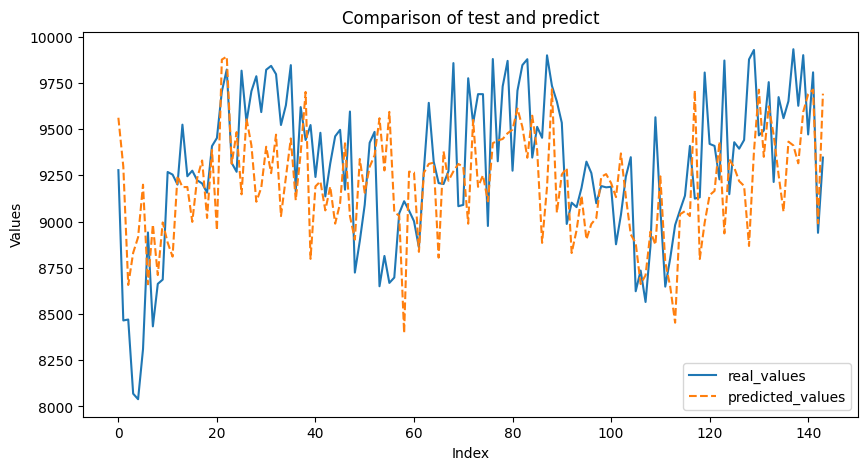

In [22]:
tft.load_model()

future_pred, future_target = tft.backtest()

plot_predictions(list(future_pred), list(future_target)) 

get prediction

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


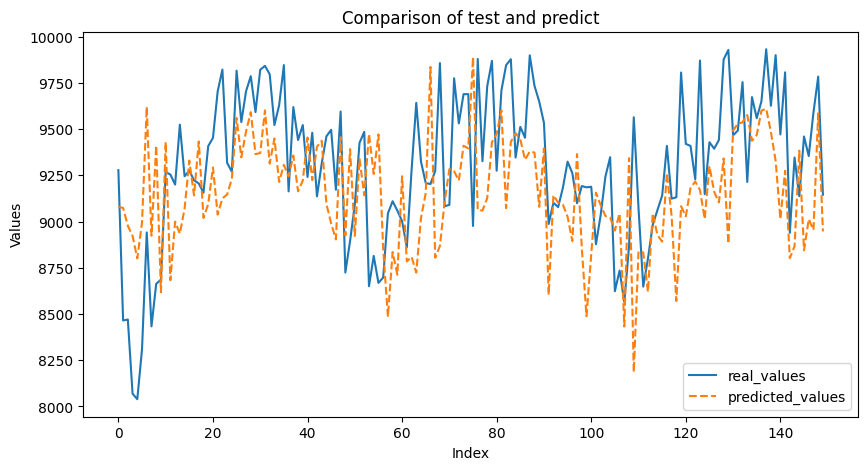

In [24]:
ans = tft.forecast()

test_ts_values = list(tft.get_true_test().values) 
ans_values = list(ans.values)  

plot_predictions(ans_values, test_ts_values) 

## Generation

create and fit the model

In [140]:
gen = TCNGAN(
            target_columns=['supply'],
            conditional_columns=['weekofyear_cos', 'weekofyear_sin'],
            window_size=100,
            num_epochs=25,
            num_layers=1,
            hidden_dim=64,
            latent_dim=2,
            verbose=True,
            lr=0.01,
            loss_type='Wasseerstein',
        )

In [141]:
gen.fit(test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type              | Params
-------------------------------------------
0 | gen  | _TCNGenerator     | 13.6 K
1 | disc | _TCNDiscriminator | 13.3 K
-------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


example of saving and loading

In [117]:
gen.save_model('D:/genrisk/generation_models/gen.pth')

In [138]:
gen.load_model('D:/genrisk/generation_models/gen.pth')

plot fake data

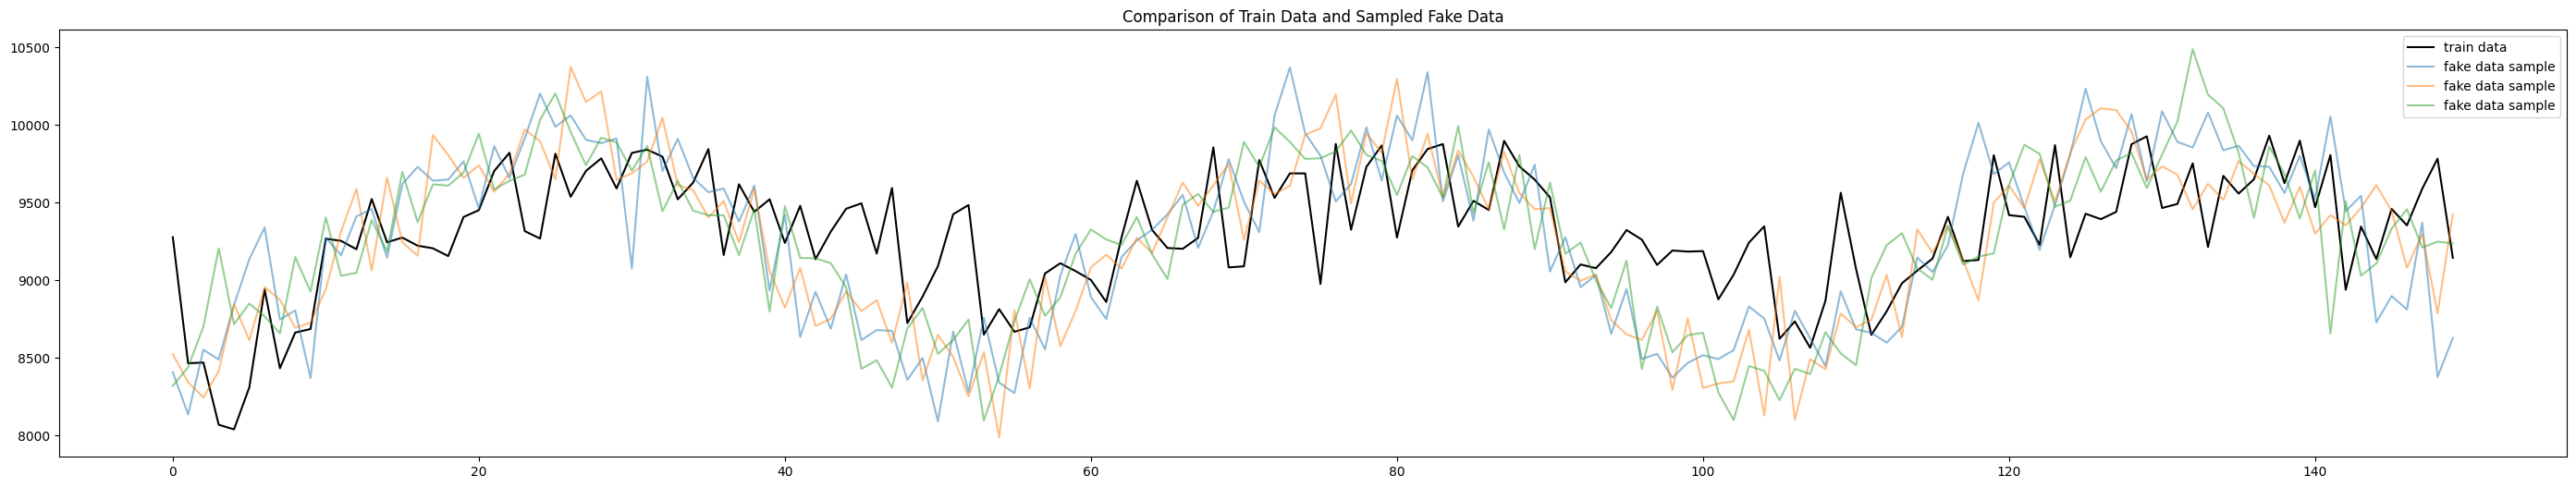

In [142]:
col = 'supply'
n_samples = 3

plot_fake_data(test, gen, col=col, n_samples=n_samples)

### Evaluation of generative model

prepare data

In [143]:
fake_data = gen.sample(test, n_samples=n_samples)

In [144]:
fake_evl = fake_data[0]['supply']
true_evl = test['supply']

different techniques to evaluate

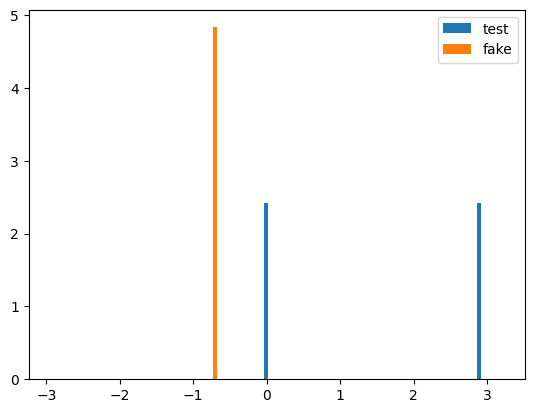

In [145]:
hist2samp(true_evl, fake_evl, 'test', 'fake', nbins=30)

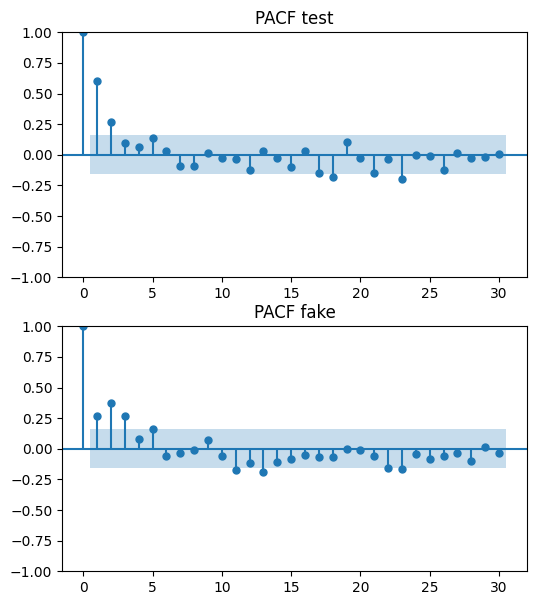

In [132]:
pacf2samp(true_evl, fake_evl, 'test', 'fake', nlags=30)

In [133]:
pacf_error(true_evl, fake_evl)

0.017821153720322523

In [134]:
ks_test(true_evl, fake_evl)

0.0002040624742534371

In [135]:
ks_lags_test(true_evl, fake_evl)

0.13659224106806578

## Worsk-case risk

create model for finding shifts

In [169]:
shift_model = ConditionalShift(
    mutable_columns=['supply'],
    immutable_columns=['weekofyear_cos', 'weekofyear_sin'],
    alpha_space=np.linspace(0.05, 0.95, 10),
    cv=5,
    # mode = 'gbr_quantiles'
)

examles to plot only fake or real worsk-case risk data

In [170]:
test

,supply,weekofyear_cos,weekofyear_sin
date,,,
2016-12-23,9278,0.939693,-0.342020
2016-12-30,8465,0.973045,-0.230616
2017-01-06,8470,0.993238,0.116093
2017-01-13,8069,0.973045,0.230616
2017-01-20,8039,0.939693,0.342020
...,...,...,...
2019-10-04,9460,-0.058145,-0.998308
2019-10-11,9354,0.058145,-0.998308
2019-10-18,9590,0.173648,-0.984808


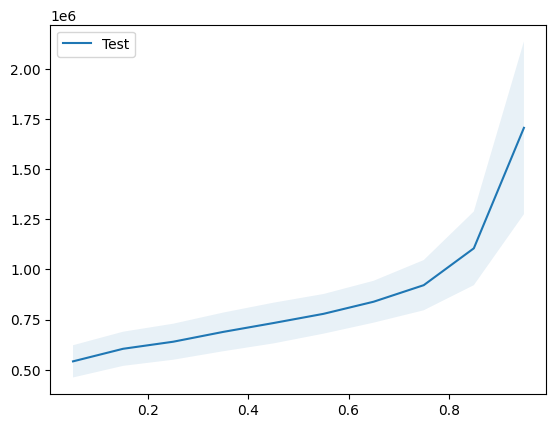

In [172]:
ans = arima.forecast().values.reshape(-1)

plot_test_wcr(ans, shift_model, test['supply'], test)

[8915.66848893 8981.08239633 9025.92499    9025.27510058 9044.86210193
 9018.61306406 9036.31053093 9073.88637112 9076.75089072 9077.9385135
 9079.77473524 9075.9057078  9072.72119249 9061.65221057 9045.14320979
 9028.62560093 9009.13774845 8986.71769582 8962.27813202 8935.53925285
 8907.69201186 8878.89200561 8849.02714964 8818.80803717 8788.66504555
 8758.94711142 8730.1148926  8702.47842683 8676.43273162 8652.37833103
 8630.61098161 8611.42295818 8571.76235973 8565.10057512 8561.91171632
 8562.23685771 8566.06695086 8573.35304488 8583.99680926 8597.85376099
 8614.73705363 8634.41762892 8656.6295382  8681.07285144 8707.41674084
 8735.30493108 8764.36033466 8794.18997459 8824.3905275  8854.55356371
 8884.27113676 8913.14139384 8940.77391612 8966.79501608 8990.85280805
 9012.62194479 9031.80803789 9048.15163252 9061.43170706 9071.4686711
 9078.1267924  9081.31603082 9080.99325803 9077.1628388  9069.87657259
 9059.23299389 9045.37603886 9028.493099   9008.81248716 8986.60034978
 8962.15

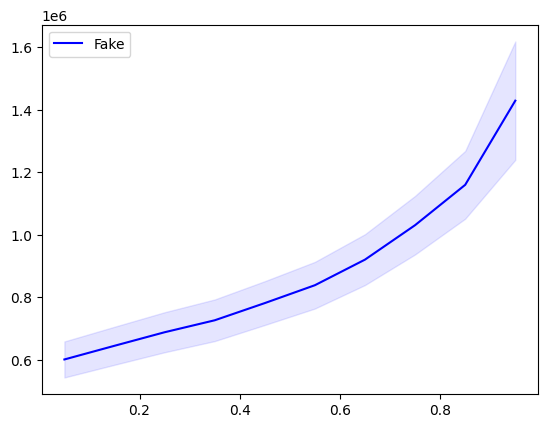

In [177]:
# arima = ARIMAModelHandler()
ans = arima.forecast().values.reshape(-1)

print(ans)

plot_fake_wcr(ans, shift_model, fake_data, col)

plot comparison of both (fake and real) worst-case risk

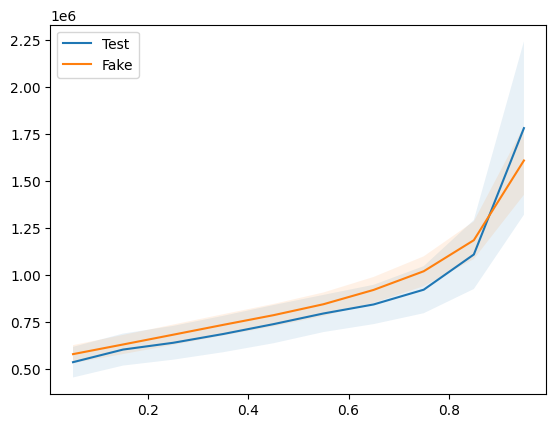

In [180]:
ans = arima.forecast().values.reshape(-1)

plot_pair_wcr(ans,
    shift_model,
    test['supply'],
    test,
    fake_data,
    col)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


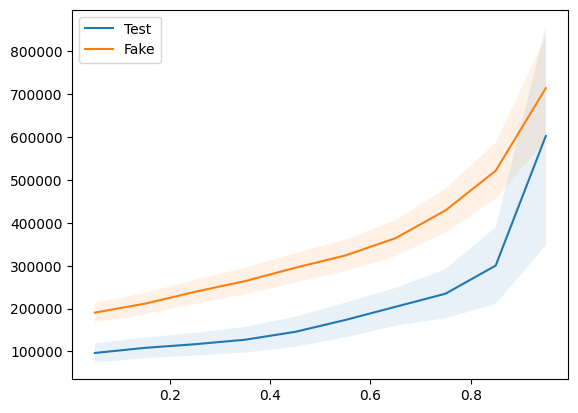

In [182]:
ans = lstm.forecast().values.reshape(-1)
plot_pair_wcr(ans,
    shift_model,
    test['supply'],
    test,
    fake_data,
    col)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


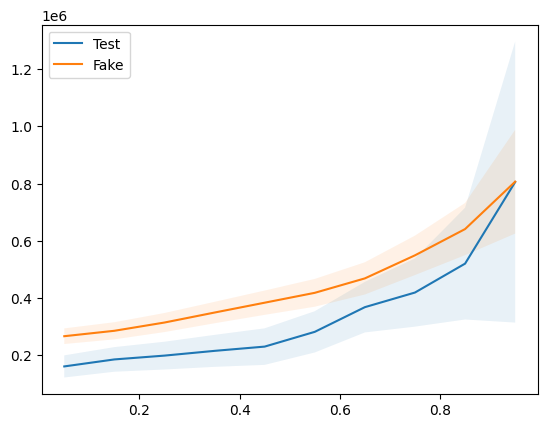

In [184]:
ans = tft.forecast().values.reshape(-1)
plot_pair_wcr(ans,
    shift_model,
    test['supply'],
    test,
    fake_data,
    col)